In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from easydict import EasyDict
import os

import warnings
from tqdm import tqdm

# Disable all warnings
warnings.filterwarnings('ignore')
from pcdet.utils import box_utils, common_utils

os.chdir("../")

### AVLRooftop dataset

In [3]:
def get_AVLRooftopDataset():
    from pcdet.datasets.avlrooftop.avlrooftop_dataset import AVLRooftopDataset
    cfg_path =  "cfgs/dataset_configs/avlrooftop/OD/avlrooftop_dataset.yaml"
    dataset_cfg = EasyDict(yaml.safe_load(open(cfg_path)))

    dataset_class_names = ["Vehicle_Drivable_Car",
                    "Vehicle_Drivable_Van",
                    "LargeVehicle_Truck",
                    "LargeVehicle_TruckCab",
                    "LargeVehicle_Bus",
                    "LargeVehicle_Bus_Bendy",
                    "Trailer",
                    "Vehicle_Ridable_Motorcycle",
                    "Vehicle_Ridable_Bicycle",
                    "Human",
                    "PPObject_Stroller"]

    return AVLRooftopDataset(dataset_cfg=dataset_cfg, class_names=dataset_class_names, training=False)
dataset = get_AVLRooftopDataset()

### AVLTruck

In [4]:
def get_AVLTruckDataset():
    from pcdet.datasets.avltruck.avltruck_dataset import AVLTruckDataset
    cfg_path =  "cfgs/dataset_configs/avltruck/OD/avltruck_dataset.yaml"
    dataset_cfg = EasyDict(yaml.safe_load(open(cfg_path)))

    dataset_class_names = ['Vehicle_Drivable_Car',
                    'Vehicle_Drivable_Van', 
                    'Vehicle_Ridable_Motorcycle', 
                    'Vehicle_Ridable_Bicycle', 
                    'Human', 
                    'LargeVehicle_Bus', 
                    'LargeVehicle_TruckCab', 
                    'LargeVehicle_Truck', 
                    'Trailer']

    return AVLTruckDataset(dataset_cfg=dataset_cfg, class_names=dataset_class_names, training=False)
dataset = get_AVLTruckDataset()

### ZOD

In [2]:
def get_ZOD_dataset():
    from pcdet.datasets.zod.zod_dataset import ZODDataset
    cfg_path =  "cfgs/dataset_configs/zod/OD/zod_dataset.yaml"
    dataset_cfg = EasyDict(yaml.safe_load(open(cfg_path)))

    dataset_class_names = ["Vehicle_Car", 
                    "Vehicle_Van", 
                    "Vehicle_Truck", 
                    "Vehicle_Trailer", 
                    "Vehicle_Bus", 
                    "Vehicle_HeavyEquip", 
                    "Vehicle_TramTrain",
                    "VulnerableVehicle_Bicycle",
                    "VulnerableVehicle_Motorcycle",
                    "Pedestrian"]

    return ZODDataset(dataset_cfg=dataset_cfg, class_names=dataset_class_names, training=False)

dataset = get_ZOD_dataset()

Loading infos: 0it [00:00, ?it/s]

In [14]:
from zod import ZodFrames
zod_frames = ZodFrames(dataset_root="/home/cgriesbacher/thesis/3DTrans/data/zod", version="mini")

zod_frames.get_all_ids()
zod_frames["007674"].get_annotation(project=)


TypeError: ZodFrame.get_annotation() missing 1 required positional argument: 'project'

In [6]:
def keep_info_with_names(info, names):
    if isinstance(names, str):
        names = [names]
    ret_info = {}
    keep_indices = [i for i, x in enumerate(info['name']) if x in names]
    for key in info.keys():
        ret_info[key] = info[key][keep_indices]
    return ret_info

def get_bbox_points(dataset, classnames, num_samples):
    frame_indices = dataset.sample_id_list

    #randomly sample 1k frames from list
    np.random.seed(2)
    frame_indices = np.random.choice(frame_indices, num_samples)

    box_points = []
    for frame_idx in tqdm(frame_indices):
        #get points in frame
        points = dataset.get_lidar(frame_idx)
        #get annotations in frame
        annos = dataset.get_label(frame_idx)
        #filter labels for "Vehicle_Drivable_Car" class
        annos = keep_info_with_names(annos, classnames)
        if len(annos['name']) == 0:
            continue

        gt_boxes_lidar = annos['gt_boxes_lidar']
        
        corners_lidar =  box_utils.boxes_to_corners_3d(annos['gt_boxes_lidar'])
        boxes_points = []
        names = []
        for i in range(annos["name"].shape[0]):
            #get points in each bbox in box coordinates

                if len(points) == 0:
                    continue
                mask = box_utils.in_hull(points[:,0:3], corners_lidar[i])
                #print(sum(mask))
                if sum(mask) == 0:
                    continue
                
                box_pts = points[mask]
                box_pts[:,0:3] -= gt_boxes_lidar[i][0:3]
                box_pts[:,0:3] = common_utils.rotate_points_along_z(box_pts[:,0:3][np.newaxis,:,:], -gt_boxes_lidar[i][6])
                box_points.append(box_pts)
                names.append(annos["name"][i])
                #angles.append(gt_boxes_lidar[i][6])

    #print(len(box_points))
    #print(len(angles))
    #box_points = np.vstack(box_points)
    #angles = np.vstack(angles)
    #
    #print(box_points.shape)
    #print(angles.shape)
    #
    ## transform points to bounding box coordinates
    #box_points[:,0:3] = common_utils.rotate_points_along_z(box_points, -angles)
    #box_points[:,0:3] -= gt_boxes_lidar[0:3]
    #
    #
    #            
    #print(len(box_points))

    #concat points
    box_points = np.concatenate(box_points, axis=0)
    return box_points, names





### Analyze number of points per frame

Loading infos: 0it [00:00, ?it/s]

1000it [00:10, 98.93it/s]
1000it [00:00, 2497.98it/s]
1000it [00:01, 528.62it/s]


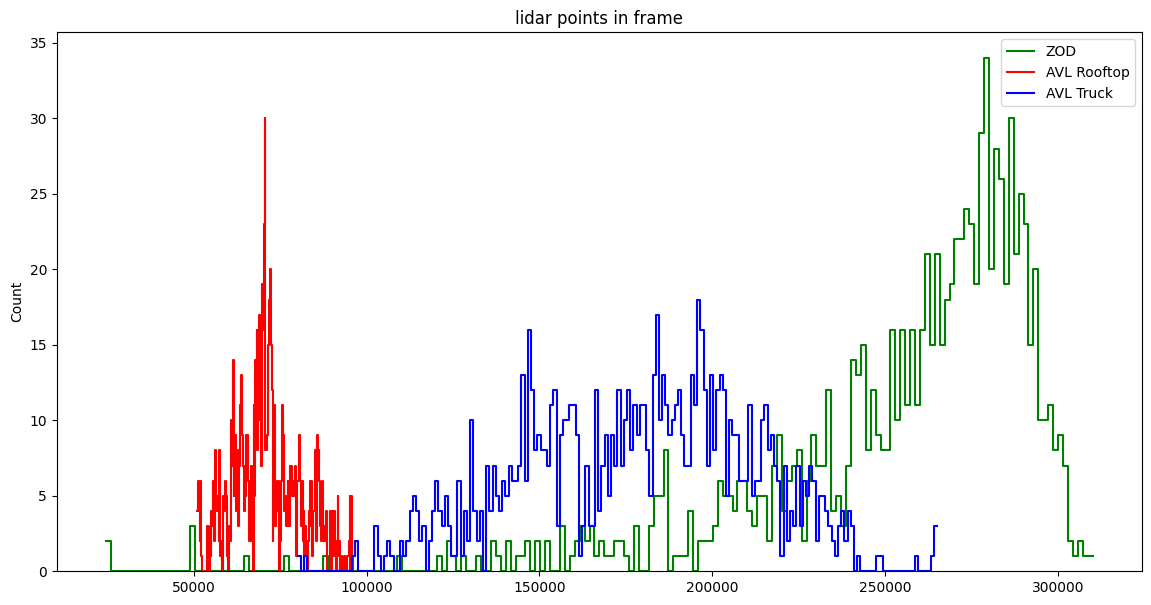

ZOD 255127.898
AVL Rooftop 71498.597
AVL Truck 178404.777


In [78]:

#get number of points each frame
def get_num_points(dataset, num_sample_frames):
    np.random.seed(2)        
    frame_indices = dataset.sample_id_list

    #randomly sample 1k frames from list
    np.random.seed(2)
    frame_indices = np.random.choice(frame_indices, num_sample_frames)

    points_per_frame = []
    for i, frame_idx in tqdm(enumerate(frame_indices)):
        #get points in frame
        points = dataset.get_lidar(frame_idx)
        
        points_per_frame.append(points.shape[0])
    
    return np.array(points_per_frame)

dataset_builders = [get_ZOD_dataset, get_AVLRooftopDataset, get_AVLTruckDataset]
labels = ["ZOD", "AVL Rooftop", "AVL Truck"]
classname = [["Vehicle_Car"], ["Vehicle_Drivable_Car"], ["Vehicle_Drivable_Car"]]
colors = ["g", "r", "b"]

points_per_dataset = []
for i, dataset in enumerate(dataset_builders):
    dataset = dataset()
    dataset.fov_points_only = False
    dataset.train_fov_only = False
    points_per_dataset.append(get_num_points(dataset, 1000))

#print sns histo of points per frame
fig, ax = plt.subplots(1,1, figsize=(14,7))
for i, dataset_pts in enumerate(points_per_dataset):
    sns.histplot(dataset_pts, ax=ax, color=colors[i], label=labels[i],  bins=100, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=True)
ax.set_title("lidar points in frame")
ax.legend()
plt.show()

#print average
for i, dataset_pts in enumerate(points_per_dataset):
    print(labels[i], np.mean(dataset_pts)) 

In [7]:
#get bbox data
dataset_builders = [get_ZOD_dataset, get_AVLRooftopDataset, get_AVLTruckDataset]
labels = ["ZOD", "AVL Rooftop", "AVL Truck"]
classname = [["Vehicle_Car"], ["Vehicle_Drivable_Car"], ["Vehicle_Drivable_Car"]]
colors = ["g", "r", "b"]
dataset_box_points = []
for i, dataset_builder in enumerate(dataset_builders):
    dataset = dataset_builder()

    box_points, name = get_bbox_points(dataset, classname[i], 500)
    dataset_box_points.append(box_points)



Loading infos: 0it [00:00, ?it/s]

  1%|          | 4/500 [00:00<01:20,  6.13it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_junction_20200309145430_1


  2%|▏         | 8/500 [00:03<05:03,  1.62it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1


  4%|▍         | 19/500 [00:09<02:04,  3.86it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2


  6%|▌         | 30/500 [00:13<02:04,  3.76it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1


  6%|▋         | 32/500 [00:17<08:27,  1.08s/it]

No 'Connected_to' attribute found in sequence CITY_Normal_junction_20200309145430_1


 10%|▉         | 49/500 [00:26<06:41,  1.12it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_roundabout_20200320100220_2


 13%|█▎        | 63/500 [00:35<05:18,  1.37it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Sunny_junction_20200512142939


 13%|█▎        | 65/500 [00:37<05:20,  1.36it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2


 15%|█▍        | 73/500 [00:39<01:45,  4.05it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1


 16%|█▌        | 79/500 [00:46<06:29,  1.08it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_junction_20200309145430_1


 22%|██▏       | 110/500 [00:57<02:02,  3.17it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Sunny_junction_20200512142939


 23%|██▎       | 114/500 [00:58<02:49,  2.28it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Sunny_junction_20200512142939


 27%|██▋       | 133/500 [01:05<01:43,  3.56it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2


 29%|██▉       | 145/500 [01:10<03:45,  1.57it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_roundabout_20200320100220_2


 31%|███       | 155/500 [01:16<02:20,  2.45it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Sunny_junction_20200512142939
No or multiple human label found for bike label in sequence INTERURBAN_Sunny_junction_20200512142939


 32%|███▏      | 159/500 [01:17<01:50,  3.10it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Sunny_junction_20200512142939


 33%|███▎      | 164/500 [01:20<02:29,  2.25it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1


 36%|███▌      | 181/500 [01:28<01:49,  2.92it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1


 43%|████▎     | 215/500 [01:40<01:31,  3.10it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Normal_roundabout_20200519125055


 45%|████▍     | 224/500 [01:42<01:11,  3.84it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1


 45%|████▌     | 227/500 [01:46<02:36,  1.74it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2


 48%|████▊     | 240/500 [01:51<01:47,  2.43it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1


 49%|████▉     | 244/500 [01:55<02:16,  1.88it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2


 51%|█████     | 254/500 [01:59<01:24,  2.90it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Normal_roundabout_20200519125055


 62%|██████▏   | 309/500 [02:16<00:37,  5.16it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1


 63%|██████▎   | 314/500 [02:19<01:08,  2.71it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_roundabout_20200320100220_2


 64%|██████▎   | 318/500 [02:22<01:33,  1.95it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Sunny_junction_20200512142939


 75%|███████▍  | 373/500 [02:36<00:20,  6.12it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Normal_roundabout_20200519125055


 77%|███████▋  | 384/500 [02:40<01:04,  1.80it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_junction_20200309145430_1


 77%|███████▋  | 386/500 [02:41<00:50,  2.27it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_roundabout_20200320100220_2


 78%|███████▊  | 390/500 [02:44<00:53,  2.07it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_roundabout_20200320100220_2


 78%|███████▊  | 391/500 [02:46<01:46,  1.02it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Normal_roundabout_20200519125055


 80%|███████▉  | 398/500 [02:49<00:57,  1.79it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2


 80%|████████  | 400/500 [02:51<01:01,  1.63it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_junction_20200309145430_1


 80%|████████  | 402/500 [02:51<00:49,  1.99it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1


 84%|████████▎ | 418/500 [02:57<00:14,  5.84it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Normal_roundabout_20200519125055


 84%|████████▍ | 420/500 [03:00<01:01,  1.30it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2


 85%|████████▍ | 424/500 [03:04<01:00,  1.25it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2


 89%|████████▉ | 447/500 [03:11<00:12,  4.17it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_junction_20200309145430_1


 97%|█████████▋| 484/500 [03:29<00:08,  1.90it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_2


 97%|█████████▋| 485/500 [03:30<00:11,  1.30it/s]

No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1
No 'Connected_to' attribute found in sequence CITY_Normal_Tjunction_20200525100547_1


 98%|█████████▊| 492/500 [03:35<00:03,  2.40it/s]

No 'Connected_to' attribute found in sequence INTERURBAN_Normal_roundabout_20200519125055


  0%|          | 1/500 [00:01<08:19,  1.00s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0


  1%|▏         | 7/500 [00:05<04:20,  1.89it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-19-15-48-20_0_s0


  2%|▏         | 9/500 [00:06<03:07,  2.62it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-03-11-29-55_0_s0


  2%|▏         | 10/500 [00:07<06:32,  1.25it/s]

No 'attributes' attribute found in sequence Motorway_dgt_2021-09-03-15-06-40_0_s0
No 'attributes' attribute found in sequence Motorway_dgt_2021-09-03-15-06-40_0_s0
No 'attributes' attribute found in sequence Motorway_dgt_2021-09-03-15-06-40_0_s0
No 'attributes' attribute found in sequence Motorway_dgt_2021-09-03-15-06-40_0_s0


  2%|▏         | 11/500 [00:08<05:08,  1.58it/s]

No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-

  3%|▎         | 13/500 [00:11<08:16,  1.02s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-14-18-00_0_s0


  3%|▎         | 14/500 [00:16<18:32,  2.29s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-14-10-06-11_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-14-10-06-11_0_s0


  3%|▎         | 15/500 [00:19<18:48,  2.33s/it]

No 'attributes' attribute found in sequence Motorway_dgt_2021-08-20-14-14-53_0_s0


  3%|▎         | 16/500 [00:19<14:09,  1.76s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-21-13-28-38_0_s0


  4%|▎         | 18/500 [00:21<11:28,  1.43s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-14-10-06-11_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-14-10-06-11_0_s0


  5%|▍         | 23/500 [00:27<07:28,  1.06it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-29-11-30-55_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-29-11-30-55_0_s0


  6%|▌         | 28/500 [00:29<03:40,  2.14it/s]

No 'with-rider' attribute found in sequence Motorway_dgt_2021-08-20-13-11-25_0_s0


  6%|▋         | 32/500 [00:31<02:21,  3.31it/s]

No 'attributes' attribute found in sequence SecondaryHighway_dgt_2021-07-14-10-37-23_0_s0


  8%|▊         | 41/500 [00:37<04:55,  1.56it/s]

No 'attributes' attribute found in sequence SecondaryHighway_dgt_2021-11-05-10-32-59_0_s0


  9%|▉         | 44/500 [00:42<10:01,  1.32s/it]

No 'with-rider' attribute found in sequence PrimaryHighway_dgt_2021-07-23-10-02-33_0_s0


  9%|▉         | 46/500 [00:45<11:14,  1.48s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-19-00_0_s0


 11%|█         | 53/500 [01:03<13:30,  1.81s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-14-10-06-11_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-14-10-06-11_0_s0


 11%|█         | 54/500 [01:06<14:54,  2.01s/it]

No 'with-rider' attribute found in sequence CityThoroughfare_dgt_2021-09-03-11-27-28_0_s0


 11%|█▏        | 57/500 [01:08<07:39,  1.04s/it]

No 'attributes' attribute found in sequence Motorway_dgt_2021-09-03-10-05-53_0_s0


 12%|█▏        | 58/500 [01:10<10:46,  1.46s/it]

No 'with-rider' attribute found in sequence Motorway_dgt_2021-08-20-12-48-38_0_s0


 12%|█▏        | 60/500 [01:14<11:36,  1.58s/it]

No 'attributes' attribute found in sequence PrimaryHighway_dgt_2021-08-19-13-08-00_0_s0


 14%|█▍        | 69/500 [01:17<02:54,  2.47it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-19-14-47-02_0_s0


 15%|█▍        | 73/500 [01:20<04:47,  1.48it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-29-09-08-03_0_s0


 15%|█▌        | 75/500 [01:23<06:21,  1.11it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-09-55-09_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-09-55-09_0_s0


 15%|█▌        | 77/500 [01:26<08:23,  1.19s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-26_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-09-09-46-

 16%|█▌        | 80/500 [01:29<06:10,  1.13it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-19-00_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-19-00_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-19-00_0_s0


 16%|█▌        | 81/500 [01:31<09:31,  1.36s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-08-20-11-09-55_0_s0


 17%|█▋        | 85/500 [01:34<05:52,  1.18it/s]

No 'attributes' attribute found in sequence SecondaryHighway_dgt_2021-07-14-10-37-23_0_s0


 18%|█▊        | 89/500 [01:35<02:58,  2.31it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-12-48-18_0_s0


 18%|█▊        | 90/500 [01:36<03:21,  2.04it/s]

No 'with-rider' attribute found in sequence SecondaryHighway_dgt_2021-07-15-12-32-26_0_s0


 19%|█▉        | 95/500 [01:43<11:45,  1.74s/it]

No 'attributes' attribute found in sequence PrimaryHighway_dgt_2021-07-21-13-11-29_0_s0
No 'attributes' attribute found in sequence PrimaryHighway_dgt_2021-07-21-13-11-29_0_s0


 20%|██        | 100/500 [01:45<04:03,  1.64it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-30-50_0_s0


 21%|██▏       | 107/500 [01:53<07:57,  1.22s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-22-13-03-24_0_s0


 22%|██▏       | 110/500 [01:55<04:30,  1.44it/s]

No 'with-rider' attribute found in sequence PrimaryHighway_dgt_2021-07-30-09-58-29_0_s0
No 'with-rider' attribute found in sequence PrimaryHighway_dgt_2021-07-30-09-58-29_0_s0


 22%|██▏       | 111/500 [01:55<03:55,  1.65it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-20-19_0_s0


 22%|██▏       | 112/500 [01:57<07:20,  1.14s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-20-13-42-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-20-13-42-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-20-13-42-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-20-13-42-19_0_s0


 24%|██▎       | 118/500 [02:06<07:54,  1.24s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-22-14-02-52_0_s0


 24%|██▍       | 121/500 [02:11<10:02,  1.59s/it]

No 'with-rider' attribute found in sequence CityThoroughfare_dgt_2021-07-16-10-03-44_0_s0


 25%|██▍       | 123/500 [02:17<13:13,  2.11s/it]

No 'with-rider' attribute found in sequence PrimaryHighway_dgt_2021-09-14-12-14-28_0_s0
No 'with-rider' attribute found in sequence PrimaryHighway_dgt_2021-09-14-12-14-28_0_s0


 26%|██▌       | 128/500 [02:20<05:32,  1.12it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-03-12-04-20_0_s0


 27%|██▋       | 135/500 [02:25<03:40,  1.66it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-04-10-04-20_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-04-10-04-20_0_s0


 28%|██▊       | 138/500 [02:29<07:53,  1.31s/it]

No 'attributes' attribute found in sequence PrimaryHighway_dgt_2021-08-19-13-08-00_0_s0


 28%|██▊       | 141/500 [02:30<03:55,  1.53it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-12-12-37-25_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-12-12-37-25_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-12-12-37-25_0_s0


 29%|██▉       | 144/500 [02:34<07:21,  1.24s/it]

No 'attributes' attribute found in sequence Motorway_dgt_2021-08-19-14-50-59_0_s0


 31%|███       | 153/500 [02:44<10:36,  1.83s/it]

No 'attributes' attribute found in sequence PrimaryHighway_dgt_2021-07-21-13-11-29_0_s0
No 'attributes' attribute found in sequence PrimaryHighway_dgt_2021-07-21-13-11-29_0_s0


 31%|███       | 156/500 [02:46<07:11,  1.25s/it]

No 'attributes' attribute found in sequence Motorway_dgt_2021-07-20-14-38-46_0_s0


 32%|███▏      | 158/500 [02:47<04:41,  1.22it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-14-54-12_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-14-54-12_0_s0


 32%|███▏      | 159/500 [02:50<09:05,  1.60s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-50-52_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-50-52_0_s0


 33%|███▎      | 166/500 [03:05<05:31,  1.01it/s]

No 'with-rider' attribute found in sequence Motorway_dgt_2021-09-03-12-48-09_0_s0
No 'with-rider' attribute found in sequence Motorway_dgt_2021-09-03-12-48-09_0_s0
No 'with-rider' attribute found in sequence Motorway_dgt_2021-09-03-12-48-09_0_s0


 33%|███▎      | 167/500 [03:05<04:18,  1.29it/s]

No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-26_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-26_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-26_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-26_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-26_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-26_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-26_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-26_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-26_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-26_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-26_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-21-15-59-

 34%|███▎      | 168/500 [03:06<04:20,  1.27it/s]

No 'attributes' attribute found in sequence PrimaryHighway_dgt_2021-08-19-13-08-00_0_s0


 34%|███▍      | 172/500 [03:11<09:03,  1.66s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-49-16_0_s0


 35%|███▍      | 174/500 [03:16<10:37,  1.96s/it]

No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0


 35%|███▌      | 175/500 [03:19<12:50,  2.37s/it]

No 'with-rider' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-42_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-15-38-

 36%|███▌      | 178/500 [03:26<10:21,  1.93s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-07-11-55-11_0_s0


 36%|███▌      | 181/500 [03:30<07:49,  1.47s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-22-13-03-24_0_s0


 36%|███▋      | 182/500 [03:31<06:07,  1.15s/it]

No 'attributes' attribute found in sequence PrimaryHighway_dgt_2021-07-29-13-22-34_0_s0


 37%|███▋      | 187/500 [03:34<03:42,  1.40it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-20-13-42-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-20-13-42-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-20-13-42-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-20-13-42-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-20-13-42-19_0_s0


 39%|███▉      | 195/500 [03:40<02:43,  1.87it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-28-55_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-28-55_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-28-55_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-28-55_0_s0


 39%|███▉      | 196/500 [03:43<05:19,  1.05s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-11-11-14-05-41_0_s0


 40%|███▉      | 199/500 [03:51<09:25,  1.88s/it]

No 'with-rider' attribute found in sequence CityThoroughfare_dgt_2021-07-16-10-03-44_0_s0


 40%|████      | 202/500 [03:57<07:59,  1.61s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-08-20-10-48-41_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-08-20-10-48-41_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-08-20-10-48-41_0_s0


 41%|████      | 206/500 [04:00<04:12,  1.16it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-08-20-11-09-55_0_s0


 41%|████▏     | 207/500 [04:00<03:37,  1.35it/s]

No 'with-rider' attribute found in sequence Motorway_dgt_2021-08-20-10-28-37_0_s0


 42%|████▏     | 209/500 [04:02<03:14,  1.49it/s]

No 'with-rider' attribute found in sequence Motorway_dgt_2021-09-15-13-40-00_0_s0
No 'with-rider' attribute found in sequence Motorway_dgt_2021-09-15-13-40-00_0_s0


 44%|████▍     | 221/500 [04:15<06:18,  1.36s/it]

No 'with-rider' attribute found in sequence SecondaryHighway_dgt_2021-07-14-10-31-39_0_s0
No 'with-rider' attribute found in sequence SecondaryHighway_dgt_2021-07-14-10-31-39_0_s0


 45%|████▍     | 223/500 [04:16<04:16,  1.08it/s]

No 'attributes' attribute found in sequence SecondaryHighway_dgt_2021-07-19-11-01-32_0_s0
No 'with-rider' attribute found in sequence SecondaryHighway_dgt_2021-07-14-10-31-39_0_s0
No 'with-rider' attribute found in sequence SecondaryHighway_dgt_2021-07-14-10-31-39_0_s0


 46%|████▌     | 229/500 [04:20<03:13,  1.40it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-

 46%|████▌     | 230/500 [04:24<07:13,  1.61s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-43-53_0_s0


 47%|████▋     | 233/500 [04:31<08:20,  1.87s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-49-16_0_s0


 48%|████▊     | 238/500 [04:39<05:58,  1.37s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-03-11-31-27_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-03-11-31-27_0_s0


 48%|████▊     | 239/500 [04:42<08:25,  1.94s/it]

No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-45-

 48%|████▊     | 240/500 [04:45<09:20,  2.16s/it]

No 'attributes' attribute found in sequence PrimaryHighway_dgt_2021-07-21-13-11-29_0_s0
No 'attributes' attribute found in sequence PrimaryHighway_dgt_2021-07-21-13-11-29_0_s0


 48%|████▊     | 242/500 [04:46<05:37,  1.31s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0


 49%|████▉     | 244/500 [04:51<07:47,  1.83s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-02-12-42-43_0_s0


 49%|████▉     | 247/500 [04:53<03:56,  1.07it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-13-11-27-56_0_s0


 50%|█████     | 252/500 [05:01<05:23,  1.31s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-09-24-52_0_s0


 51%|█████     | 254/500 [05:08<09:06,  2.22s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-04-10-04-20_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-04-10-04-20_0_s0


 51%|█████     | 256/500 [05:09<05:17,  1.30s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-11-08-13-54-24_0_s0


 52%|█████▏    | 259/500 [05:12<04:17,  1.07s/it]

No 'with-rider' attribute found in sequence CityThoroughfare_dgt_2021-07-19-09-26-44_0_s0


 53%|█████▎    | 264/500 [05:15<02:15,  1.74it/s]

No 'with-rider' attribute found in sequence PrimaryHighway_dgt_2021-07-30-09-58-29_0_s0
No 'with-rider' attribute found in sequence PrimaryHighway_dgt_2021-07-30-09-58-29_0_s0


 54%|█████▍    | 270/500 [05:17<01:45,  2.18it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-07-12-13-57_0_s0


 54%|█████▍    | 271/500 [05:20<03:54,  1.02s/it]

No 'attributes' attribute found in sequence SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0


 54%|█████▍    | 272/500 [05:20<03:04,  1.23it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-11-29-10-09-07_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-11-29-10-09-07_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-11-29-10-09-07_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-11-29-10-09-07_0_s0


 55%|█████▌    | 277/500 [05:26<03:33,  1.04it/s]

No 'attributes' attribute found in sequence SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0
No 'attributes' attribute found in sequence SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-08-44-44_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-

 57%|█████▋    | 283/500 [05:34<03:25,  1.06it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-03-11-31-27_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-03-11-31-27_0_s0


 57%|█████▋    | 285/500 [05:37<04:37,  1.29s/it]

No 'with-rider' attribute found in sequence PrimaryHighway_dgt_2021-07-08-10-39-39_0_s0
No 'with-rider' attribute found in sequence PrimaryHighway_dgt_2021-07-08-10-39-39_0_s0


 57%|█████▋    | 286/500 [05:38<04:01,  1.13s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-17_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-08-15-32-

 57%|█████▋    | 287/500 [05:44<08:56,  2.52s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-04-10-04-20_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-04-10-04-20_0_s0


 59%|█████▊    | 293/500 [05:48<02:50,  1.22it/s]

No 'attributes' attribute found in sequence Motorway_dgt_2021-08-20-14-31-58_0_s0


 59%|█████▉    | 296/500 [05:50<01:52,  1.81it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-14-27-30_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-14-27-30_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-14-27-30_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-14-27-30_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-14-27-30_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-14-27-30_0_s0


 60%|██████    | 300/500 [05:53<01:59,  1.67it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-08-20-11-09-55_0_s0


 60%|██████    | 302/500 [05:54<02:01,  1.63it/s]

No 'with-rider' attribute found in sequence Motorway_dgt_2021-08-20-12-48-38_0_s0


 61%|██████▏   | 307/500 [06:01<05:05,  1.58s/it]

No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0


 62%|██████▏   | 308/500 [06:05<07:12,  2.25s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-20-10-54-29_0_s0


 62%|██████▏   | 309/500 [06:06<06:06,  1.92s/it]

No 'with-rider' attribute found in sequence PrimaryHighway_dgt_2021-07-12-13-38-27_0_s0
No 'with-rider' attribute found in sequence PrimaryHighway_dgt_2021-07-12-13-38-27_0_s0


 62%|██████▏   | 311/500 [06:07<03:55,  1.25s/it]

No 'with-rider' attribute found in sequence CityThoroughfare_dgt_2021-08-20-11-10-13_0_s0


 63%|██████▎   | 316/500 [06:12<02:45,  1.11it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-02-12-42-43_0_s0


 64%|██████▎   | 318/500 [06:16<05:03,  1.67s/it]

No 'attributes' attribute found in sequence Motorway_dgt_2021-09-03-15-06-40_0_s0
No 'attributes' attribute found in sequence Motorway_dgt_2021-09-03-15-06-40_0_s0
No 'attributes' attribute found in sequence Motorway_dgt_2021-09-03-15-06-40_0_s0
No 'attributes' attribute found in sequence Motorway_dgt_2021-09-03-15-06-40_0_s0


 64%|██████▍   | 320/500 [06:17<02:58,  1.01it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-08-20-10-48-41_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-08-20-10-48-41_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-08-20-10-48-41_0_s0


 64%|██████▍   | 321/500 [06:18<03:18,  1.11s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-14-09-55-12_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-14-09-55-12_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-14-09-55-12_0_s0


 66%|██████▌   | 328/500 [06:26<03:44,  1.31s/it]

No 'attributes' attribute found in sequence Motorway_dgt_2021-08-20-14-31-58_0_s0


 67%|██████▋   | 333/500 [06:31<02:27,  1.13it/s]

No 'attributes' attribute found in sequence SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0


 67%|██████▋   | 336/500 [06:32<01:47,  1.52it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-08-30-12-48-18_0_s0


 68%|██████▊   | 339/500 [06:37<03:25,  1.28s/it]

No 'attributes' attribute found in sequence SecondaryHighway_dgt_2021-07-19-11-01-32_0_s0


 68%|██████▊   | 341/500 [06:37<02:20,  1.13it/s]

No 'attributes' attribute found in sequence Motorway_dgt_2021-08-19-14-47-35_0_s0


 69%|██████▉   | 345/500 [06:39<01:29,  1.73it/s]

No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-14-14-21_0_s0


 70%|███████   | 352/500 [06:45<01:19,  1.86it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0


 71%|███████   | 355/500 [06:54<04:33,  1.89s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-28-55_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-28-55_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-28-55_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-15-28-55_0_s0


 73%|███████▎  | 363/500 [07:02<01:51,  1.23it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-15-11-04-49_0_s0


 73%|███████▎  | 364/500 [07:07<04:39,  2.06s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0


 73%|███████▎  | 365/500 [07:14<07:42,  3.43s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-07-13-33-38_0_s0


 73%|███████▎  | 366/500 [07:17<07:32,  3.38s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-09-55-09_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-09-55-09_0_s0


 74%|███████▍  | 369/500 [07:22<04:18,  1.98s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-02-55_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-02-55_0_s0


 74%|███████▍  | 370/500 [07:24<04:12,  1.95s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-02-55_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-02-55_0_s0


 75%|███████▌  | 377/500 [07:28<01:28,  1.38it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-09-38-01_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-09-38-01_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-09-38-01_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-09-38-01_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-09-38-01_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-09-38-01_0_s0


 76%|███████▌  | 379/500 [07:31<02:04,  1.03s/it]

No 'with-rider' attribute found in sequence CityThoroughfare_dgt_2021-08-20-11-10-13_0_s0


 76%|███████▋  | 382/500 [07:33<01:34,  1.25it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-29-09-08-03_0_s0


 77%|███████▋  | 385/500 [07:36<01:27,  1.31it/s]

No 'attributes' attribute found in sequence SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0


 77%|███████▋  | 387/500 [07:37<01:21,  1.38it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-09-50-44_0_s0


 79%|███████▊  | 393/500 [07:41<01:04,  1.65it/s]

No 'attributes' attribute found in sequence Motorway_dgt_2021-08-20-10-19-03_0_s0


 79%|███████▉  | 394/500 [07:42<01:00,  1.75it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0


 79%|███████▉  | 396/500 [07:45<01:45,  1.02s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-04-11_0_s0


 80%|███████▉  | 398/500 [07:51<02:47,  1.64s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-10-10-40_0_s0


 80%|████████  | 402/500 [07:58<02:18,  1.41s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-10-13-35_0_s0


 81%|████████  | 404/500 [08:00<01:47,  1.12s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-29-11-30-55_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-29-11-30-55_0_s0


 81%|████████▏ | 407/500 [08:00<00:55,  1.66it/s]

No 'with-rider' attribute found in sequence CityThoroughfare_dgt_2021-07-19-09-26-44_0_s0


 82%|████████▏ | 409/500 [08:01<00:51,  1.77it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-09-07-52-00_0_s0


 82%|████████▏ | 410/500 [08:04<01:53,  1.26s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-23-10-13-35_0_s0


 82%|████████▏ | 411/500 [08:06<02:10,  1.47s/it]

No 'with-rider' attribute found in sequence Motorway_dgt_2021-09-15-09-29-02_0_s0


 82%|████████▏ | 412/500 [08:07<01:56,  1.32s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-14-20-55_0_s0


 83%|████████▎ | 416/500 [08:10<01:00,  1.40it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-22-13-03-24_0_s0


 84%|████████▎ | 418/500 [08:14<01:36,  1.17s/it]

No 'attributes' attribute found in sequence Motorway_dgt_2021-09-03-14-45-44_0_s0


 84%|████████▍ | 420/500 [08:16<01:19,  1.00it/s]

No 'attributes' attribute found in sequence SecondaryHighway_dgt_2021-07-23-13-02-47_0_s0


 85%|████████▍ | 423/500 [08:19<01:29,  1.17s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-09-16-12-25-18_0_s0


 85%|████████▌ | 426/500 [08:24<01:51,  1.51s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-54_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-32-

 86%|████████▌ | 428/500 [08:30<02:23,  1.99s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0


 87%|████████▋ | 436/500 [08:40<01:04,  1.00s/it]

No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-09-09-09-55_0_s0


 89%|████████▉ | 444/500 [08:55<01:13,  1.31s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-08_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-06-13-12-

 89%|████████▉ | 447/500 [09:02<01:34,  1.78s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0


 90%|████████▉ | 448/500 [09:07<02:18,  2.66s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-19-14-52-03_0_s0


 91%|█████████ | 455/500 [09:19<01:29,  1.99s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-04-10-04-20_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-04-10-04-20_0_s0


 91%|█████████ | 456/500 [09:20<01:08,  1.56s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'with-rider' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-13-11-42-06_0_s0


 92%|█████████▏| 458/500 [09:25<01:24,  2.02s/it]

No 'attributes' attribute found in sequence Motorway_dgt_2021-09-03-15-27-44_0_s0


 92%|█████████▏| 461/500 [09:29<00:55,  1.43s/it]

No 'attributes' attribute found in sequence Motorway_dgt_2021-07-20-14-38-46_0_s0


 93%|█████████▎| 463/500 [09:31<00:39,  1.07s/it]

No 'attributes' attribute found in sequence Motorway_dgt_2021-08-19-14-50-59_0_s0


 93%|█████████▎| 466/500 [09:33<00:31,  1.07it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-22-14-02-52_0_s0


 94%|█████████▍| 469/500 [09:37<00:40,  1.30s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-07-11-54-36_0_s0


 96%|█████████▌| 478/500 [09:48<00:25,  1.18s/it]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-21-13-28-15_0_s0


 96%|█████████▋| 482/500 [09:53<00:16,  1.06it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-02-55_0_s0
No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-07-16-12-02-55_0_s0


 98%|█████████▊| 489/500 [09:57<00:04,  2.50it/s]

No 'attributes' attribute found in sequence CityThoroughfare_dgt_2021-11-11-14-05-41_0_s0


 98%|█████████▊| 491/500 [10:01<00:08,  1.05it/s]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-57_0_s0
No 'attributes' attribute found in sequence CityStreet_dgt_2021-07-14-09-51-

100%|█████████▉| 498/500 [10:10<00:02,  1.19s/it]

No 'attributes' attribute found in sequence CityStreet_dgt_2021-11-30-09-35-40_0_s0


100%|█████████▉| 499/500 [10:14<00:01,  1.91s/it]

No 'attributes' attribute found in sequence Motorway_dgt_2021-07-20-14-46-20_0_s0


100%|██████████| 500/500 [10:15<00:00,  1.23s/it]


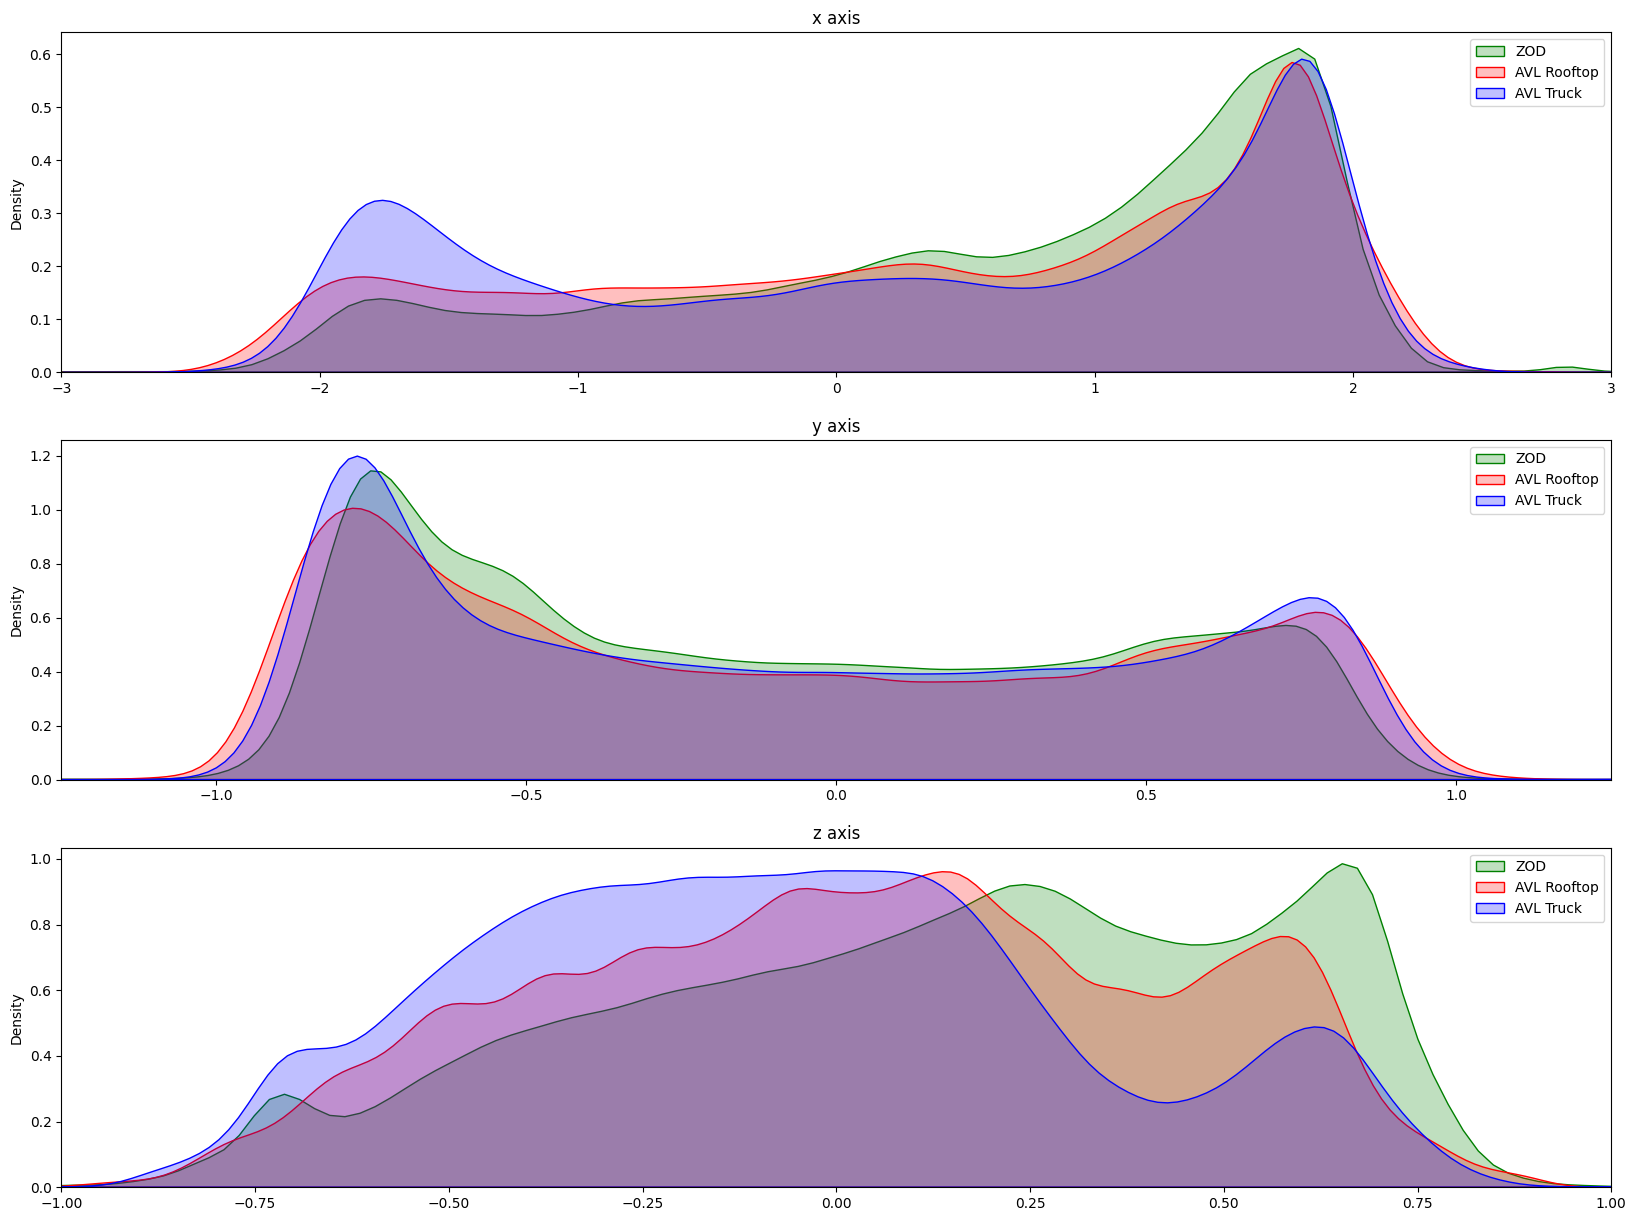

In [9]:
# for each dataset plot a normalized histogram of the points over all boxes for x, y and z axis
fig, ax = plt.subplots(3,1, figsize=(20,15))
for i, dataset in enumerate(dataset_box_points):
    sns.distplot(dataset[:,0], ax=ax[0], color=colors[i], hist=False, kde_kws={"shade": True, "fill":False}, label=labels[i])
    sns.distplot(dataset[:,1], ax=ax[1], color=colors[i], hist=False, kde_kws={"shade": True, "fill":False}, label=labels[i])
    sns.distplot(dataset[:,2], ax=ax[2], color=colors[i], hist=False, kde_kws={"shade": True, "fill":False}, label=labels[i])
ax[0].set_title("x axis")
ax[1].set_title("y axis")
ax[2].set_title("z axis")
ax[0].legend()
ax[1].legend()
ax[2].legend()
#set limits
ax[0].set_xlim([-3,3])
ax[1].set_xlim([-1.25,1.25])
ax[2].set_xlim([-1,1])

plt.show()



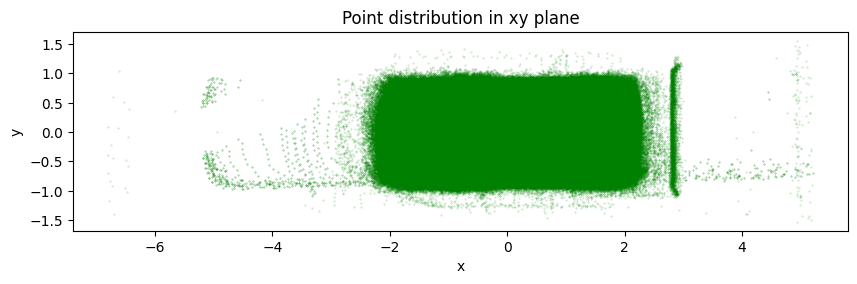

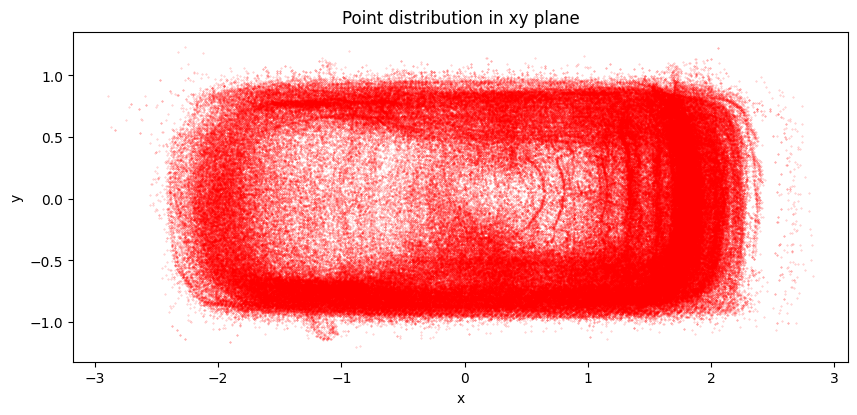

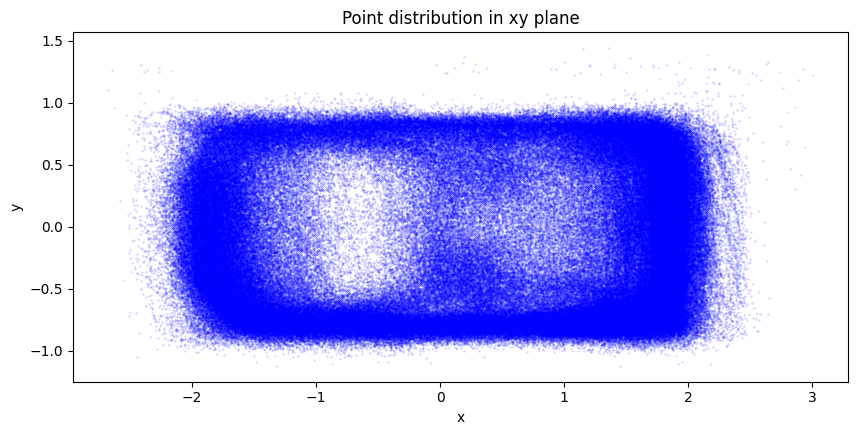

In [10]:
for i, box_points in enumerate(dataset_box_points):    
    plt.figure(figsize=(10,10))
    #plot point distribution in xy plane
    plt.scatter(box_points[:,0], box_points[:,1], s=0.1, alpha=0.33, c=colors[i])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Point distribution in xy plane")
    #aspect ratio 1:1
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

### Analyze points in frames

In [13]:
def get_random_points(dataset, num_sample_frames, num_sample_points):
    np.random.seed(2)        
    frame_indices = dataset.sample_id_list

    #randomly sample 1k frames from list
    np.random.seed(2)
    frame_indices = np.random.choice(frame_indices, num_sample_frames)

    points_array = np.zeros([num_sample_frames*num_sample_points,4])
    for i, frame_idx in tqdm(enumerate(frame_indices)):
        #get points in frame
        points = dataset.get_lidar(frame_idx)
        
        points = points[np.random.choice(points.shape[0], num_sample_points)]

        points_array[i*num_sample_points:num_sample_points*(i+1)] = points

    return points_array


In [14]:

#get random points from datasets
dataset_builders = [get_ZOD_dataset, get_AVLRooftopDataset, get_AVLTruckDataset]
labels = ["ZOD", "AVL Rooftop", "AVL Truck"]
classname = [["Vehicle_Car"], ["Vehicle_Drivable_Car"], ["Vehicle_Drivable_Car"]]
colors = ["g", "r", "b"]
points = []
for i, dataset_builder in enumerate(dataset_builders):
    dataset = dataset_builder()

    points_dataset = get_random_points(dataset, 500, 10000)
    points.append(points_dataset)

Loading infos: 0it [00:00, ?it/s]

500it [00:24, 20.42it/s]
500it [00:01, 350.46it/s]
500it [00:04, 108.73it/s]


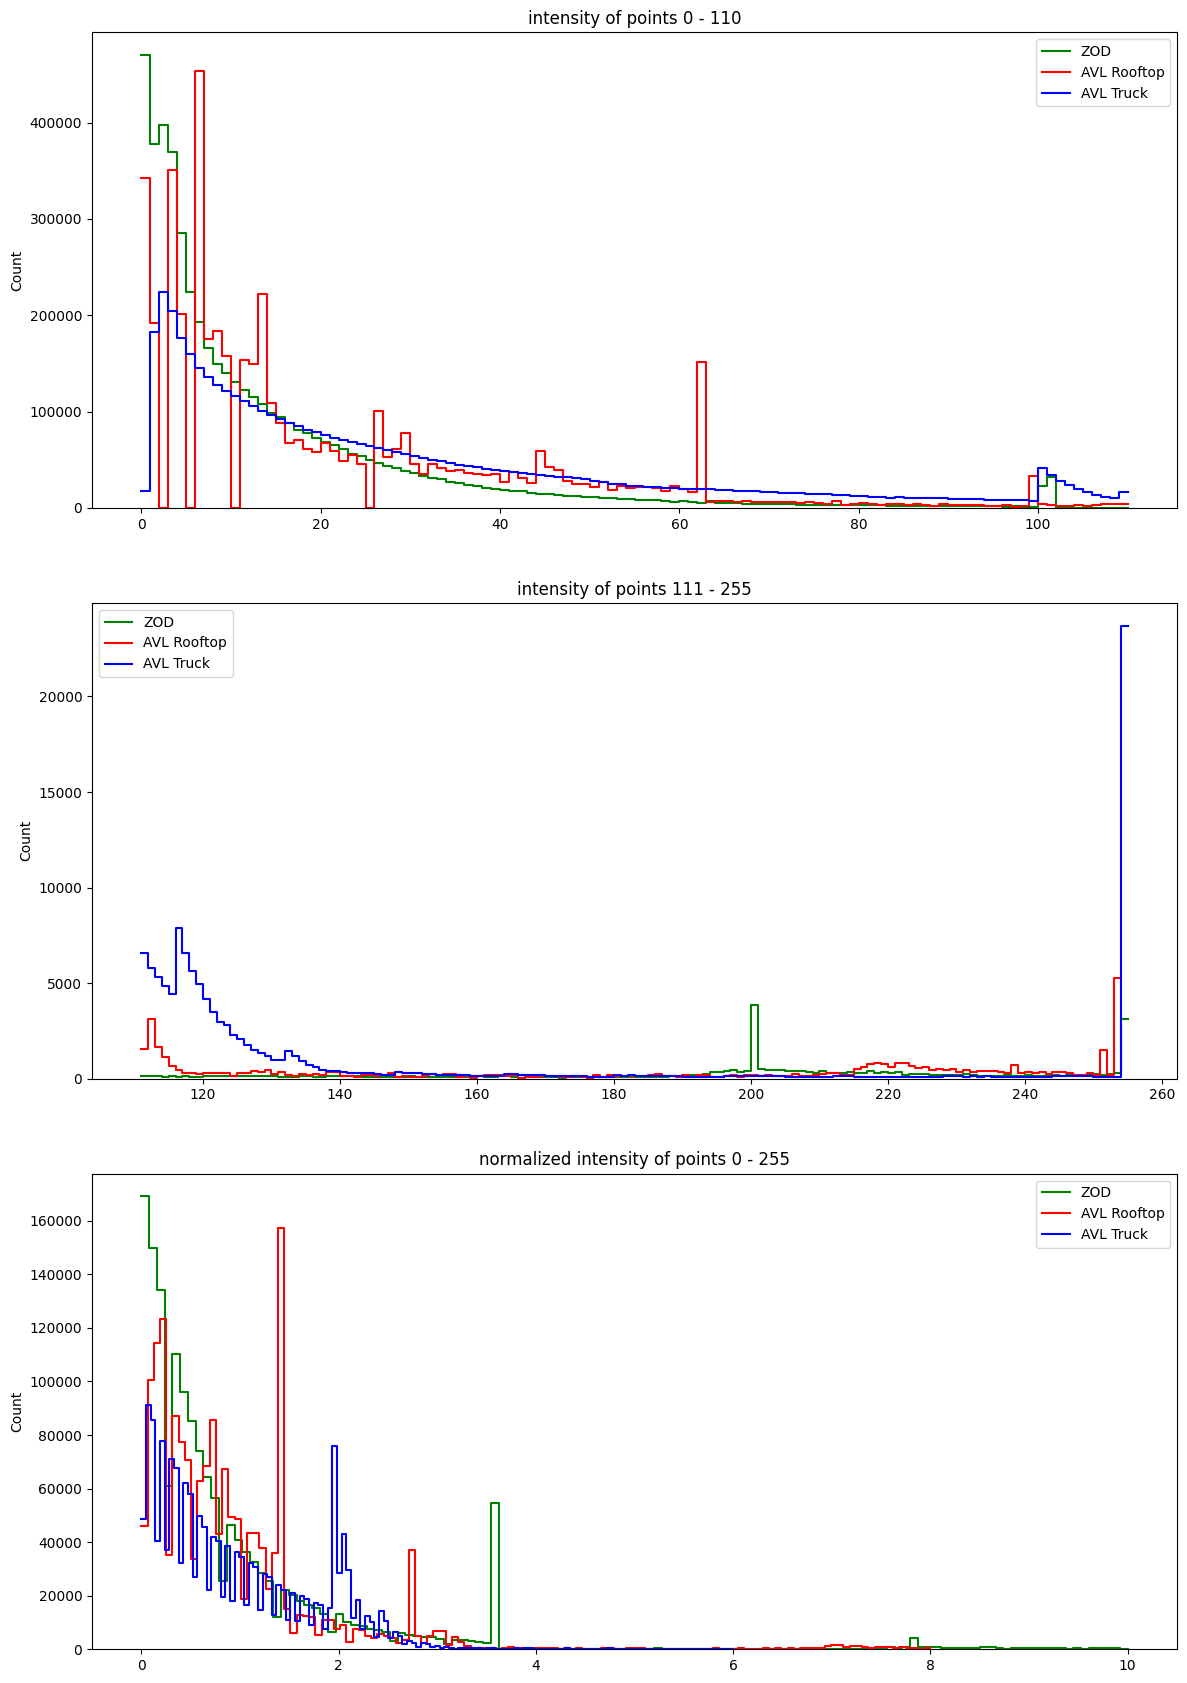

In [33]:
#analyze intensity of points
fig, ax = plt.subplots(3,1, figsize=(14,21))
for i, dataset_pts in enumerate(points):
    points_intensity = dataset_pts[:,3].copy() 
    points_intensity*=255
    points_intensity = points_intensity.astype(int)
    #filter points with intensity lower than 0.5
    pts_low = points_intensity[points_intensity <= 110]       
    bins = range(min(pts_low), max(pts_low) + 1)
    sns.histplot(pts_low, ax=ax[0], color=colors[i], label=labels[i],  bins=bins, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=False)
    
    pts_high = points_intensity[points_intensity > 110]
    bins = range(min(pts_high), max(pts_high) + 1)
    sns.histplot(pts_high, ax=ax[1], color=colors[i], label=labels[i],  bins=bins, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=False)
    #sns.distplot(dataset_pts[:,3], ax=ax, color=colors[i], hist=False, kde_kws={"shade": True, "bw_adjust": 0.1}, label=labels[i])
    
    #normalize intensity to have mean zero and std 1
    norm_points = (points_intensity - np.mean(points_intensity))/np.std(points_intensity)
    bins = np.linspace(int(min(norm_points)), int(max(norm_points)), 128)
    sns.histplot(norm_points, ax=ax[2], color=colors[i], label=labels[i],  bins=bins, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=False)

ax[0].set_title("intensity of points 0 - 110")
ax[1].set_title("intensity of points 111 - 255")
ax[2].set_title("normalized intensity of points 0 - 255")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()


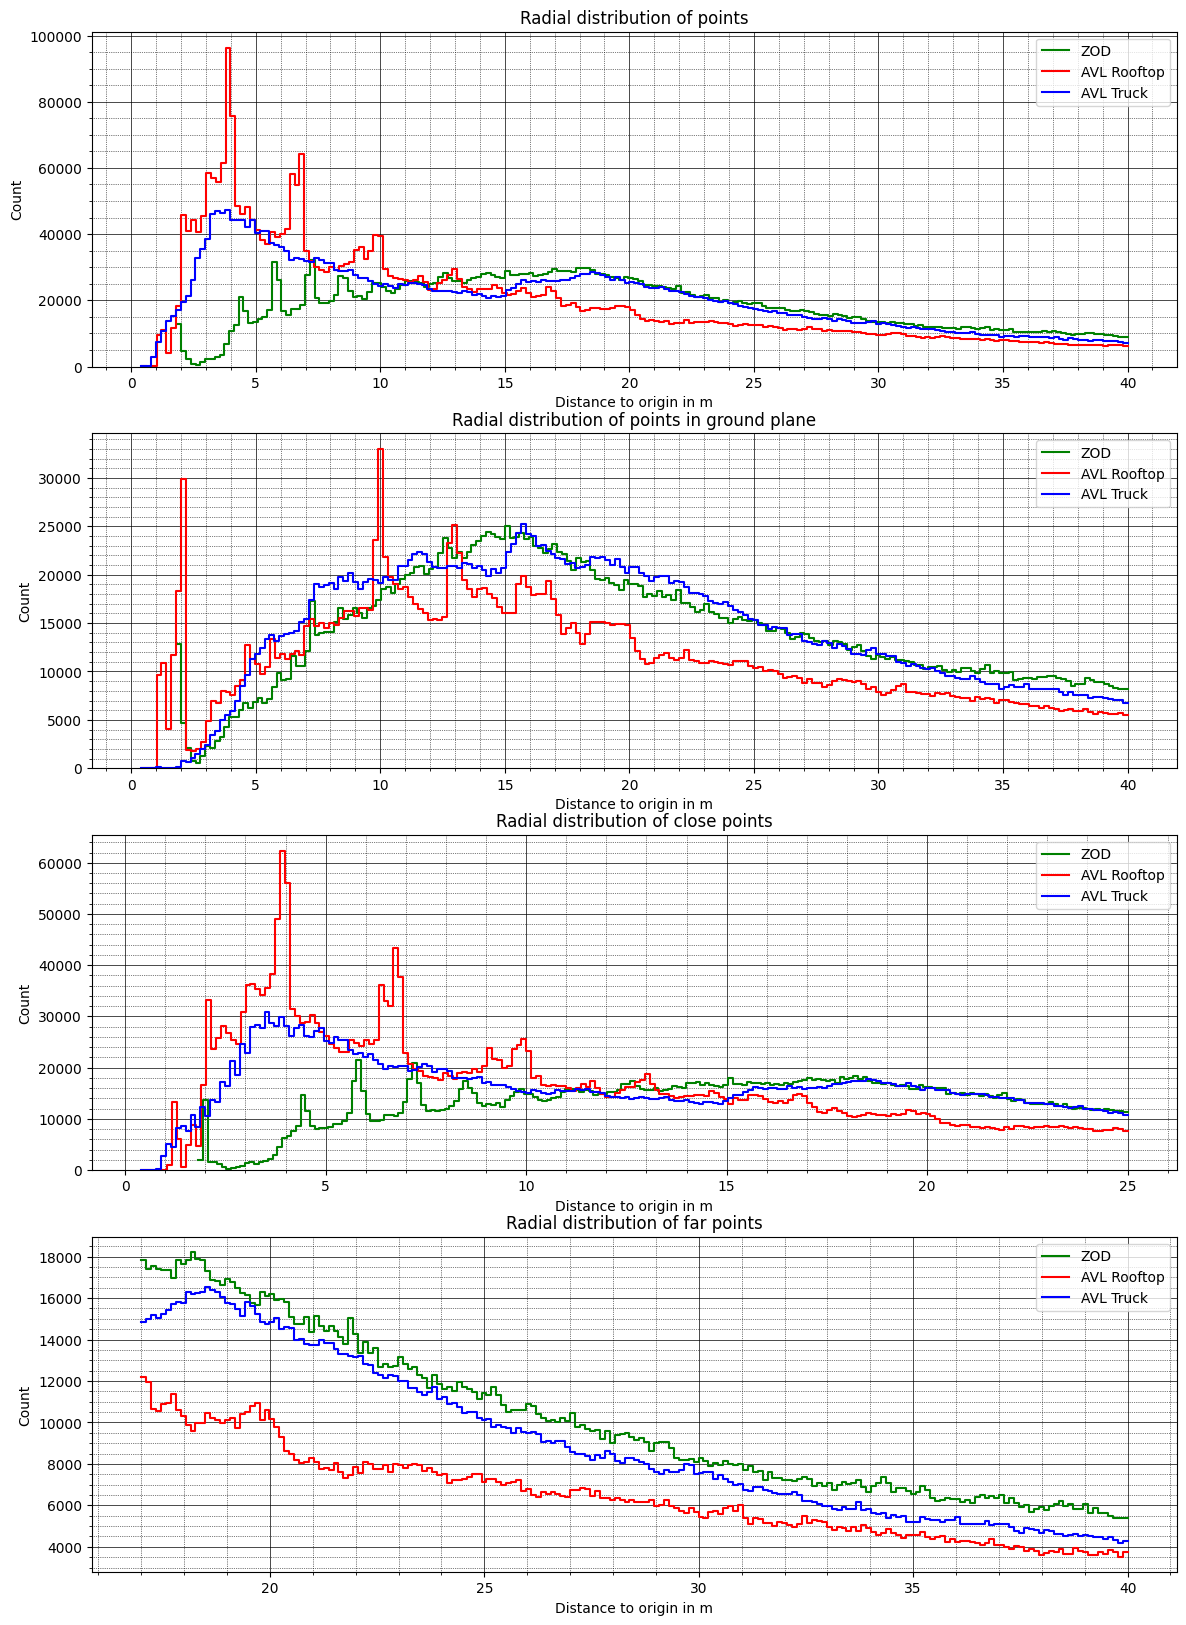

In [79]:
#print radial data dist
fig, ax = plt.subplots(4,1, figsize=(14,20))
x_limits = [0,40]
x_limits_far = [17,40]
x_limits_close= [0,25]
for i, pts in enumerate(points):

    dists = np.linalg.norm(pts[:,0:2], axis=1)
    #filter points within x_limits
    dists = dists[np.logical_and(dists > x_limits[0], dists < x_limits[1])]

    sns.histplot(dists, ax=ax[0], color=colors[i], label=labels[i], bins=200, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=True)
    
    dists_close = dists[np.logical_and(dists > x_limits_close[0], dists < x_limits_close[1])]
    sns.histplot(dists_close, ax=ax[2], color=colors[i], label=labels[i], bins=200, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=True)

    dists_far = dists[np.logical_and(dists > x_limits_far[0], dists < x_limits_far[1])]
    sns.histplot(dists_far, ax=ax[3], color=colors[i], label=labels[i], bins=200, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=True)

    #filter gt plane points
    pts = pts[np.abs(pts[:,2]) < 0.2]
    
    #filter points within x_limits
    dists_ground = np.linalg.norm(pts[:,0:2], axis=1)
    dists_ground = dists_ground[np.logical_and(dists_ground > x_limits[0], dists_ground < x_limits[1])]
    sns.histplot(dists_ground, ax=ax[1], color=colors[i], label=labels[i], bins=200, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", common_bins=True)

ax[0].set_title("Radial distribution of points")
ax[2].set_title("Radial distribution of close points")
ax[3].set_title("Radial distribution of far points")
ax[1].set_title("Radial distribution of points in ground plane")
for i in range(4):
    ax[i].legend()
    ax[i].set_xlabel("Distance to origin in m")
    ax[i].set_axisbelow(True)
    ax[i].grid(True)
    ax[i].minorticks_on()
    ax[i].grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

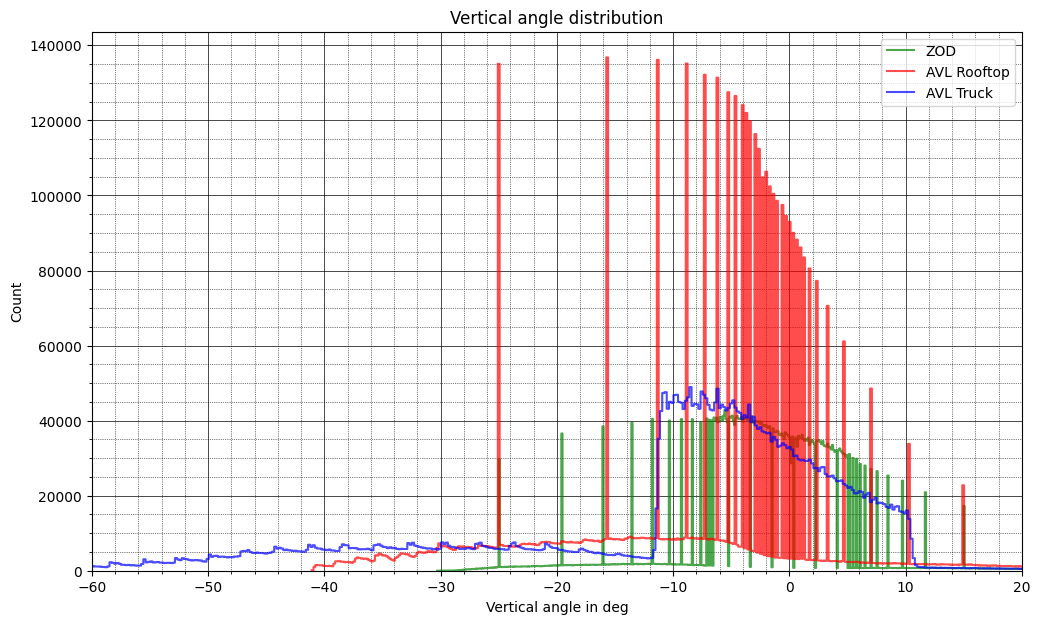

In [34]:
#print vertical angle dist
lidar_heights = [2.08702246, 1.7715138, 3.4097]
fig, ax = plt.subplots(1,1, figsize=(12,7))
#x_limits = [-20,40]
for i, pts in enumerate(points):
    #filter points within x_limits
    #pts = pts[np.logical_and(pts[:,0] > x_limits[0], pts[:,0] < x_limits[1])]
    alphas = np.arctan2(pts[:,2] - lidar_heights[i], np.linalg.norm(pts[:,0:2], axis=1))
    alphas = np.rad2deg(alphas)
    #sns.distplot(alphas, ax=ax, color=colors[i], hist=False,  kde_kws={"shade": True, "bw_adjust":0.01}, label=labels[i])
    sns.histplot(alphas, ax=ax, color=colors[i], label=labels[i], bins=600, kde=False, kde_kws={"bw_adjust": 0.1}, fill=False, cumulative=False,  element="step", alpha=0.7, stat="count")

#ax.set_xlim(x_limits)
ax.set_title("Vertical angle distribution")
ax.set_xlabel("Vertical angle in deg")
ax.legend()
ax.set_axisbelow(True)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.set_xlim([-60,20])
plt.show()